In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)
from functions.model3 import GAN
import datetime
import json
from qiskit.circuit import ParameterVector
from functions.data_preperation import process_model_data
from functions.q_generator import two_qubit_circuit_tickers
from functions.model_test import plot_training_metrics, get_latest_model_path, calculate_rmse, infer_parameter_groups, plot_rmse_per_epoch

2.20.0
GPU devices: []


In [2]:
model_directory ="models/"
latest_model_path = get_latest_model_path(model_directory)
#latest_model_path="models/models_2809.1230"

In [3]:
targets = ["OC_next", "CO_next"]
features = ["Close", "High", "Low", "Open", "Volume", "MACD", "Signal_Line", "EMA_20"]
tickers = ['GOOG','AAPL','MSFT','AMZN']

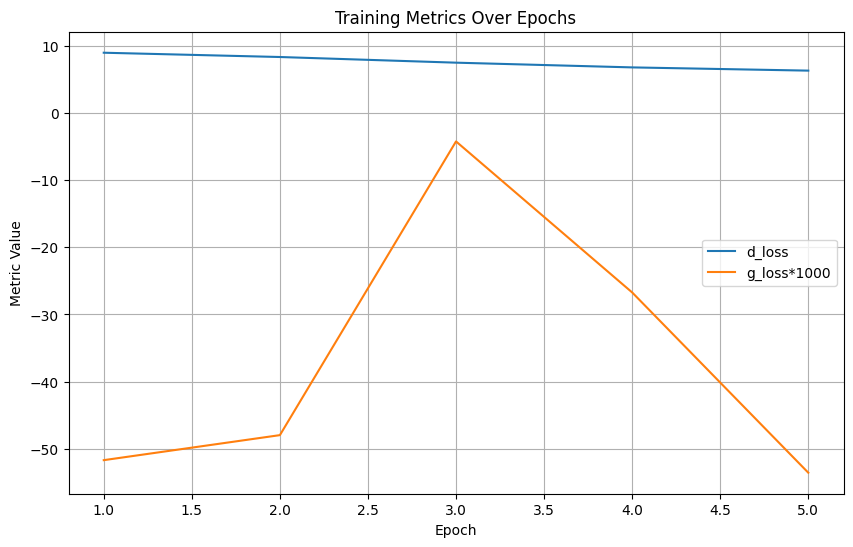

In [9]:
plot_training_metrics(f"{latest_model_path}/logs", generator_loss_scaling=1000)

In [11]:
feature_data, target_data = process_model_data(targets, features, tickers) #feature_data, target_data

c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust

(1004, 32) (1004, 8)


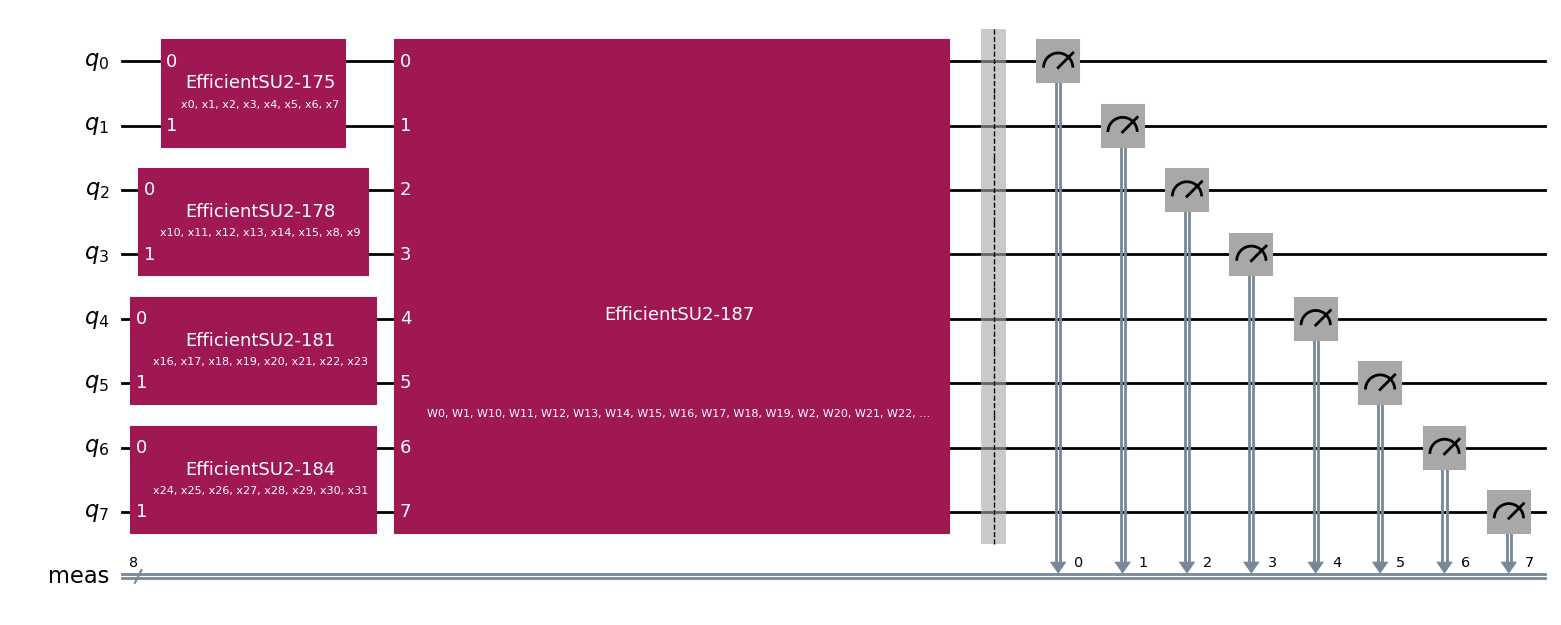

In [12]:
qc= two_qubit_circuit_tickers(tickers)
qc.draw('mpl')

## Loading weights into the model

In [14]:
#latest_model_path="models/models_2809.1018"
loaded_weights = np.load(f"{latest_model_path}/generator.npy")

In [ ]:
data_params, weight_params = infer_parameter_groups(qc)

In [ ]:
# mapping from Parameters to values
weight_param_dict = {param: val for param, val in zip(weight_params, loaded_weights)}

# Assign parameters to the circuit
qc_weighted = qc.assign_parameters(weight_param_dict)

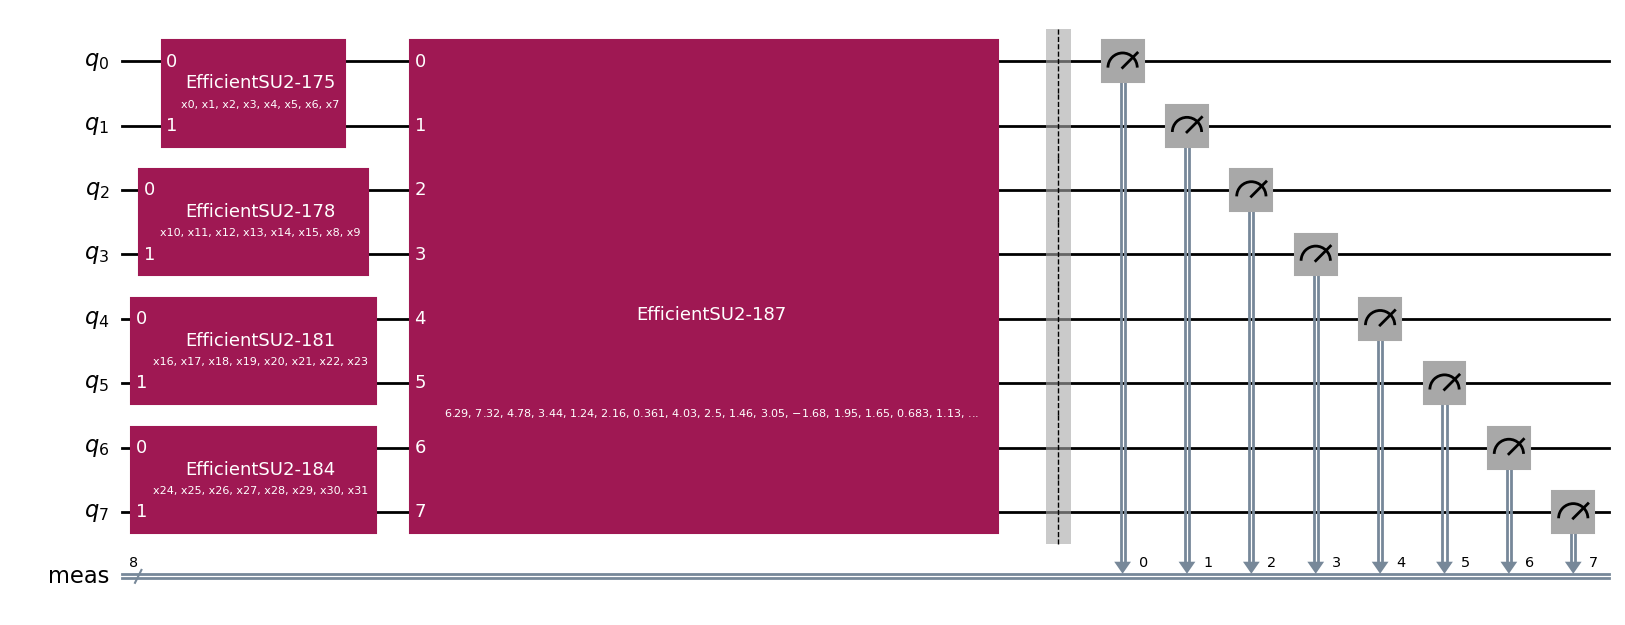

In [18]:
qc_weighted.draw('mpl')

### Encode data

In [42]:
#load in example data
input_data = feature_data[0]

#data_params = list(qc_weighted.parameters)
data_param_dict = {param: val for param, val in zip(data_params, input_data)}

print (data_param_dict)
# Assign data encodings to the circuit
qc_data = qc_weighted.assign_parameters(data_param_dict)


{Parameter(x0): -3.114508566595936, Parameter(x1): -3.128512281695925, Parameter(x10): -3.102226595158314, Parameter(x11): -3.127273951654059, Parameter(x12): -2.260857859364241, Parameter(x13): -1.0043936432030423, Parameter(x14): -1.1283162537636273, Parameter(x15): -3.140921191327359, Parameter(x16): -2.928103006437952, Parameter(x17): -2.9548338642296423, Parameter(x18): -2.890824378787691, Parameter(x19): -2.9216151109148876, Parameter(x2): -1.5221760809785019, Parameter(x20): 0.27385622905046647, Parameter(x21): 0.008237797823615445, Parameter(x22): -3.141592653589793, Parameter(x23): -3.054432811437849, Parameter(x24): -3.044504574858196, Parameter(x25): -3.014052339017291, Parameter(x26): -3.0434760271614265, Parameter(x27): -1.8544302521470988, Parameter(x28): -0.7192863290367648, Parameter(x29): -0.8785821901978301, Parameter(x3): -3.141592653589793, Parameter(x30): -0.18413510520773713, Parameter(x31): -0.14171180091247537, Parameter(x4): -0.12450018023531317, Parameter(x5):

### Run the circuit

In [22]:
from qiskit.quantum_info import SparsePauliOp
num_qubits = qc_weighted.num_qubits
observable = [SparsePauliOp.from_list([(f"{'I'*i}Z{'I'*(num_qubits-i-1)}", 1)]) for i in range(num_qubits)]

print(observable)

[SparsePauliOp(['ZIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IZIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIZIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIZIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIZIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIZII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIZI'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIZ'],
              coeffs=[1.+0.j])]


In [48]:
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit import transpile

service = QiskitRuntimeService()
#backend = service.least_busy()
backend = GenericBackendV2(num_qubits=num_qubits)
qc_transpiled = transpile(qc_data, backend=backend, optimization_level=3)

estimator = EstimatorV2(mode=backend)

pub = (qc_transpiled, observable) #primitive unified bloc program input for estimator
job = estimator.run([pub])
result = job.result()[0]
expectation_values = result.data.evs

management.get:WARNING:2025-09-28 20:42:59,101: Loading default saved account


In [49]:
expectation_values

array([ 0.28613281,  0.796875  ,  0.12109375, -0.06640625, -0.28076172,
        0.06103516, -0.48974609,  0.03027344])

In [50]:
target_data[0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-0.13254137, -0.3487708 , -0.66223794,  0.6015468 , -0.54447484,
       -0.845509  , -0.3418808 , -0.0632446 ], dtype=float32)>

## Finding the Root Mean Squared Errors
This is a better accuracy metric for us as the generator/discriminator loss doesn't tell us much

An RMSE of 0.10 means we are off by 10%

In [ ]:
loaded_weights = np.load(f"{latest_model_path}/generator.npy")
rmse_dict = calculate_rmse(loaded_weights, targets, tickers, features)

c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust

(1004, 32) (1004, 8)


Processing inputs: 100%|██████████| 1004/1004 [04:15<00:00,  3.94it/s]

GOOG_OC_next: 0.4453
GOOG_CO_next: 0.7058
AAPL_OC_next: 1.0350
AAPL_CO_next: 0.9203
MSFT_OC_next: 0.9277
MSFT_CO_next: 0.8128
AMZN_OC_next: 0.6230
AMZN_CO_next: 0.4222


c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust

(1004, 32) (1004, 8)


Processing inputs: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)


GOOG_OC_next: 0.5160
GOOG_CO_next: 0.4251
AAPL_OC_next: 1.0622
AAPL_CO_next: 0.9049
MSFT_OC_next: 0.8975
MSFT_CO_next: 0.7884
AMZN_OC_next: 0.7019
AMZN_CO_next: 0.4376


[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


(1004, 32) (1004, 8)


Processing inputs: 100%|██████████| 100/100 [00:26<00:00,  3.79it/s]
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)


GOOG_OC_next: 0.5571
GOOG_CO_next: 0.4314
AAPL_OC_next: 1.0730
AAPL_CO_next: 0.9694
MSFT_OC_next: 0.9063
MSFT_CO_next: 0.8496
AMZN_OC_next: 0.6695
AMZN_CO_next: 0.3938


[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


(1004, 32) (1004, 8)


Processing inputs: 100%|██████████| 100/100 [00:27<00:00,  3.60it/s]
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)


GOOG_OC_next: 0.4889
GOOG_CO_next: 0.3991
AAPL_OC_next: 0.9814
AAPL_CO_next: 1.0566
MSFT_OC_next: 0.8916
MSFT_CO_next: 0.8854
AMZN_OC_next: 0.8143
AMZN_CO_next: 0.3627


[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


(1004, 32) (1004, 8)


Processing inputs: 100%|██████████| 100/100 [00:22<00:00,  4.51it/s]
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)


GOOG_OC_next: 0.3913
GOOG_CO_next: 0.5458
AAPL_OC_next: 1.0336
AAPL_CO_next: 0.9268
MSFT_OC_next: 0.8850
MSFT_CO_next: 0.8816
AMZN_OC_next: 0.7055
AMZN_CO_next: 0.3032


[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


(1004, 32) (1004, 8)


Processing inputs: 100%|██████████| 100/100 [00:21<00:00,  4.66it/s]


GOOG_OC_next: 0.4877
GOOG_CO_next: 0.6310
AAPL_OC_next: 1.0306
AAPL_CO_next: 0.8425
MSFT_OC_next: 0.8894
MSFT_CO_next: 0.7290
AMZN_OC_next: 0.5669
AMZN_CO_next: 0.3752


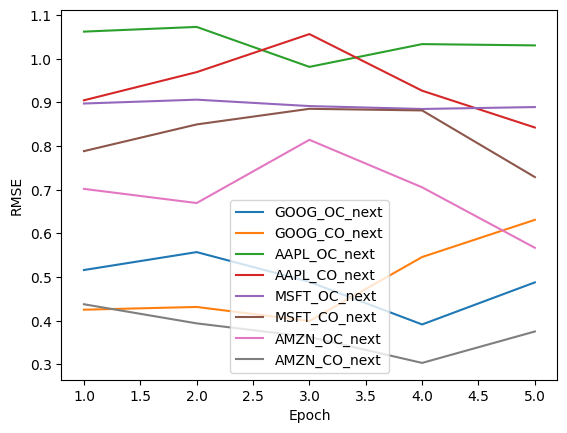

In [ ]:
plot_rmse_per_epoch(latest_model_path, targets, tickers, features, sample_size=100)